In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange
import random
%matplotlib inline

## Generate fake data

In [5]:
from sklearn.datasets import make_blobs
# Create Data
data, labels = make_blobs(n_samples=400, n_features=2, 
                           centers=2, cluster_std=3., random_state=100)
x = data[:,0]
y = data[:,1]

In [6]:
#np.random.rand(3,2)

### Visualize

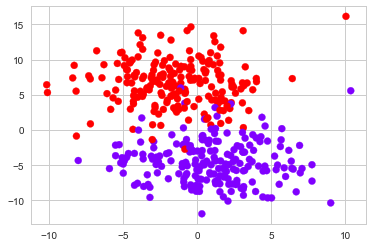

In [7]:
sns.set_style("whitegrid")
plt.scatter(x , y, c = labels, cmap='rainbow')

### Now, lets apply Scikit-lear's EM GMM for binary classification

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.mixture import GaussianMixture               

In [12]:
n_centroids = 2

In [13]:
gm = GaussianMixture(n_components=n_centroids,
                     random_state=100,
                     n_init=1,
                     max_iter=100)
gm.fit(data)
gm_labels = gm.predict(data)

print(confusion_matrix(labels, gm_labels))
print(classification_report(labels, gm_labels))

[[191   9]
 [  6 194]]
             precision    recall  f1-score   support

          0       0.97      0.95      0.96       200
          1       0.96      0.97      0.96       200

avg / total       0.96      0.96      0.96       400



In [14]:
[[x_cen1, y_cen1],[x_cen2, y_cen2]] = gm.means_

## Plot with predicted labels

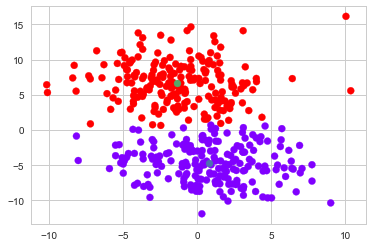

In [15]:
sns.set_style("whitegrid")
plt.scatter(x , y, c = gm_labels, cmap='rainbow')
plt.scatter(x_cen1,y_cen1,cmap='rainbow')
plt.scatter(x_cen2,y_cen2)

## Let's write a code for EM GMM

In [11]:
#random_index = randrange(0,len(data[0]))

In [16]:
steps = 100
x_cen1, y_cen1 = [10,1] #data[0][random_index]
x_cen2, y_cen2 = [1,1] #data[0][random_index] + [1,-8]

In [17]:

for i in range(steps):    
    
    #calculate distances from each centroid to all data points
    dist1 = (x - x_cen1)**2 + (y - y_cen1)**2 
    dist2 = (x - x_cen2)**2 + (y - y_cen2)**2     
   
    # calculate stds
    std1 = np.std(np.sqrt(dist1))
    std2 = np.std(np.sqrt(dist2))
    
    #Expectation part: estimate gaussian likelihood
    p1 = np.exp((-1.0* dist1)/(2 * std1))
    p2 = np.exp((-1.0* dist2)/(2 * std2))
    ex1 = p1 / sum(p1)
    ex2 = p2 / sum(p2)
    
    #maximization part: recalculate centers
    x_cen1, y_cen1 = np.sum(np.dot(x,ex1)) , np.sum(np.dot(y,ex1)) 
    x_cen2, y_cen2 = np.sum(np.dot(x,ex2)) , np.sum(np.dot(y,ex2)) 

#np.array([[x_cen1,y_cen1],[x_cen2,y_cen2]])
       

In [14]:
#pd.DataFrame([ex1, ex2]).transpose()

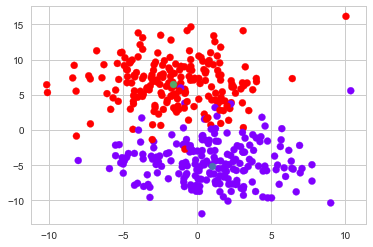

In [18]:
sns.set_style("whitegrid")
plt.scatter(data[:,0],data[:,1],c=labels,cmap='rainbow')
plt.scatter(x_cen1,y_cen1,cmap='rainbow')
plt.scatter(x_cen2,y_cen2)


## Scalable and vectorized

In [19]:
cents = np.array([[10,1],[1,1]])


In [20]:
from scipy.spatial.distance import cdist

def Estep(x_inp, x_cent):
    '''Performs the E step given input np.matrix and centroid locations as matrix '''
   
    #calculate distances from each centroid to all data points
    dist = cdist(x_inp, x_cent, 'euclidean')
    expect = np.empty(shape=[len(x_cent), len(x_inp)]).transpose()
    for i in range(len(x_cent)):
        #compute the standard deviations
        std = dist[:,i].std() 
        # Expectation step
        expect[:,i] = np.exp((-0.50 * dist[:,i]**2 / std))
        expect[:,i] = expect[:,i] / expect[:,i].sum()
    return expect

In [21]:
def Mstep(x_inp, expect):
    '''Performs the M step given input np.matrix and expectation values '''
   
    #Maximization Step
    centroids = np.dot(x_inp.transpose(),expect)
    return centroids.T

In [23]:
def simulate_EM(x_inp, x_cents, steps):
    for i in range(steps):
        expect = Estep(data, x_cents)
        x_cents = Mstep(data, expect)
    return x_cents

In [24]:
x_cents = simulate_EM(data, cents,100)

In [25]:
x_cen1, y_cen1 = x_cents[0]
x_cen2, y_cen2 = x_cents[1]

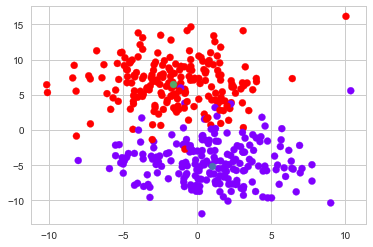

In [26]:
sns.set_style("whitegrid")
plt.scatter(data[:,0],data[:,1],c=labels,cmap='rainbow')
plt.scatter(x_cen1,y_cen1,cmap='rainbow')
plt.scatter(x_cen2,y_cen2)